# Upload data to Colab

In [0]:
import json
from pprint import pprint
from google.colab import auth
from googleapiclient.discovery import build
import io
from googleapiclient.http import MediaIoBaseDownload
import pickle

**You'll be prompted for your google credentials after running next cell**

In [0]:
auth.authenticate_user()
drive_service = build('drive', 'v3')

In [0]:
def _create_file_request(file_id):
    return drive_service.files().get_media(fileId=file_id)


def _download_response_bytes(request, print_progress=False):
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    
    for status in _progbar(downloader):
        if print_progress:
            print("Downloaded {}/{} bytes".format(status.resumable_progress, status.total_size))
  
    downloaded.seek(0)
    return downloaded.read()

  
def _progbar(downloader):
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        yield status


def get_file_id(name):
    return get_matching_files(name)[0]['id']


def move_from_drive_to_disk(file_names, file_destinations):
    for file_name, dest in zip(file_names, file_destinations):
        file_id = get_file_id(file_name)
        print('Downloading file: "{}"'.format(file_name))
        file_bytes = _download_response_bytes(_create_file_request(file_id), print_progress=True)
        with open(dest, "wb") as f:
            f.write(file_bytes)


def load_pickled_files(file_names):
    for name in file_names:
        yield pickle.load(open(name, "rb"))
        

def get_matching_files(name):
    drive_files_response = _download_response_bytes(drive_service.files().list())
    drive_files_response_dict = json.loads(
        drive_files_response.decode('utf-8')
    )
    drive_files_dict = drive_files_response_dict['files']
  
    matching_records = [
        record
        for record in drive_files_dict
        if record['name'] == name
    ]

    no_records = len(matching_records)
    if no_records == 0:
        raise ValueError('no such file: "{}" on your Google Drive'.format(name))
    elif no_records > 1:
        print('warning: multiple matches for file "{}"'.format(name))
    return matching_records

Assume you have file named `data.zip` on your google drive.

In [4]:
example_file_name = 'train_test_data.zip'
example_file_id = get_file_id(example_file_name)

In [5]:
move_from_drive_to_disk([example_file_name], ['train_test_data.zip'])

Downloaded 104857601/212781105 bytes
Downloaded 209715202/212781105 bytes
Downloaded 212781105/212781105 bytes


In [6]:
!unzip train_test_data.zip
!rm train_test_data.zip
!mv train_test_data data

Archive:  train_test_data.zip
   creating: train_test_data/
   creating: train_test_data/dt05_bth/
  inflating: train_test_data/dt05_bth/F01_050C0103_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C0105_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010C_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010G_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010J_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010K_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010L_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010O_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010P_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010R_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010U_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C010W_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C0112_BTH.CH1.wav  
  inflating: train_test_data/dt05_bth/F01_050C0116_BTH.C

# Import libraries

In [7]:
%matplotlib inline

! pip install -q librosa nltk

import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import matplotlib.pyplot as plt
import numpy as np
import librosa
import glob
from librosa.core import load, stft, magphase, istft
from librosa.output import write_wav

from keras import initializers, layers, models
from keras.utils.conv_utils import conv_output_length, deconv_length

plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['image.cmap'] = 'hot'

Using TensorFlow backend.


# Preprocess data

In [0]:
def extract_spectrogram_patches(spec, n_fft, patch_window, patch_hop):
    spec3d = np.expand_dims(spec, axis=0)
    spec4d = np.expand_dims(spec3d, axis=3)

    patches = tf.extract_image_patches(
        images=spec4d,
        ksizes=[1, patch_window, 1 + n_fft / 2, 1],
        strides=[1, patch_hop, 1 + n_fft / 2, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    ).eval()

    num_patches = patches.shape[1]

    return np.reshape(patches, (num_patches, patch_window, int(1 + n_fft // 2), 1))

def roll(arr,shift):
    shape = arr.shape
    arr = arr.reshape(shape[0]*shape[1],shape[2],shape[3])
    arr = np.roll(arr, shift, axis=0)
    return arr.reshape(shape[0],shape[1],shape[2],shape[3])

In [0]:
def preprocess_training_data(
        mixed_pattern = '/content/data/dt05_bus_simu/F01*.wav',
        voice_pattern = '/content/data/dt05_bth/F01*.wav',
        sample_rate = 44100,
        n_fft = 1024,
        fft_hop = 256,
        patch_window = 256,
        patch_hop = 128,
):
    
    def extract_data(path):
        #Downloading data from an audio file
        audio, _ = librosa.load(path, sr=sample_rate, mono=True)
        #Converting audio data to a spectrogram (using the Window Fourier transform)
        spec = librosa.stft(audio, n_fft=n_fft, hop_length=fft_hop, window='hann')
        #Separate magnitude from phase (hereinafter, only magnitude will be used for training)
        mag, _ = magphase(spec)
        mag = mag.T.astype(np.float32)
        #increase the data and divide into equal pieces
        # for example: a = ([1,2,3,4,5],[6,7,8,9,10],[11,12,13,14,15]) ->
        # a[0] = ([1,2,3,4,5],[6,7,8,9,10])
        # a[1] = ([6,7,8,9,10],[11,12,13,14,15])
        with tf.Session() as sess:
            spectrogram_patches = extract_spectrogram_patches(mag, n_fft, patch_window, patch_hop)
        spectrogram_patches = spectrogram_patches[:,:,:512,:]
        
        return spectrogram_patches
    
    mixed_paths = sorted(glob.glob(mixed_pattern))
    voice_paths = sorted(glob.glob(voice_pattern))
    
    #creating a folder where training data will be stored
    newpath = r'/content/data/train_data' 
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    newpath = r'/content/data/norm_train_data' 
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    
    if len(mixed_paths)==len(voice_paths):
        i=0
        for mixed_path, voice_path in zip(mixed_paths, voice_paths):
            mixed_spectrogram_patches = extract_data(mixed_path)
            voice_spectrogram_patches = extract_data(voice_path)
            #apply the bias to the voice, since the voice was obtained bias initially 
            voice_spectrogram_patches = roll(voice_spectrogram_patches,-4)
            #save processed data to train_data/
            for mixed_patch, voice_patch in zip(mixed_spectrogram_patches, voice_spectrogram_patches):
                np.savez(f'/content/data/train_data/{i}.npz', x=mixed_patch, y=voice_patch)#save without normalization
                #Apply normalization №1(
                mix_voice_max=max(mixed_patch.max(),voice_patch.max())
                mixed_patch=mixed_patch/mix_voice_max
                voice_patch=voice_patch/mix_voice_max
                #)
                np.savez(f'/content/data/norm_train_data/{i}.npz', x=mixed_patch, y=voice_patch)#save with normalization
                i=i+1
    else:
        print("len(mixed_paths)!=len(voice_paths)")

preprocess_training_data()

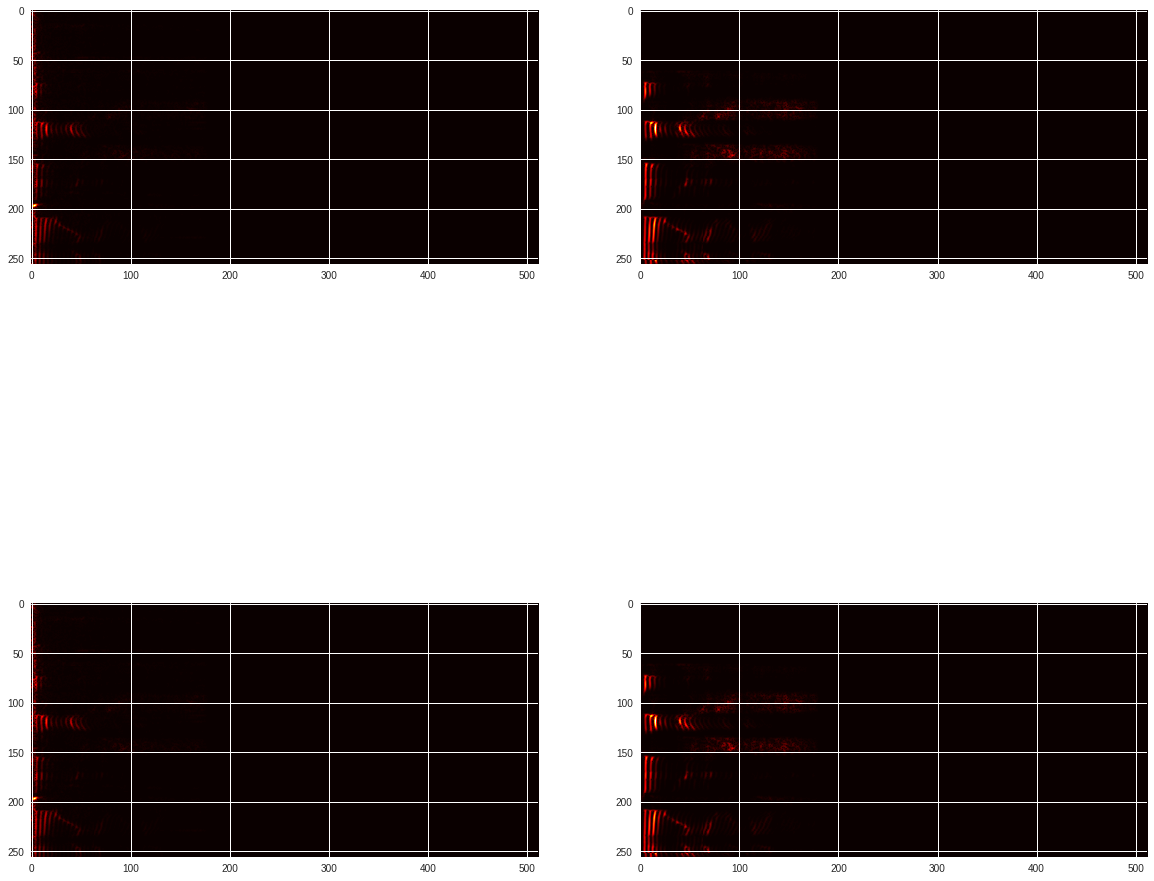

In [10]:
npz = np.load('/content/data/train_data/0.npz')
npz2 = np.load('/content/data/norm_train_data/0.npz')

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(20,20))
ax1.imshow(npz['x'][:, :, 0])
ax2.imshow(npz['y'][:, :, 0])
ax3.imshow(npz2['x'][:, :, 0])
ax4.imshow(npz2['y'][:, :, 0])

# Train model

In [0]:
class ConvCapsuleLayer(layers.Layer):
    def __init__(self, kernel_size, num_capsule, num_atoms, strides=1, padding='same', routings=3,
                 kernel_initializer='he_normal', **kwargs):
        super(ConvCapsuleLayer, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.num_capsule = num_capsule
        self.num_atoms = num_atoms
        self.strides = strides
        self.padding = padding
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) == 5, "The input Tensor should have shape=[None, input_height, input_width," \
                                      " input_num_capsule, input_num_atoms]"
        self.input_height = input_shape[1]
        self.input_width = input_shape[2]
        self.input_num_capsule = input_shape[3]
        self.input_num_atoms = input_shape[4]

        # Transform matrix
        self.W = self.add_weight(shape=[self.kernel_size, self.kernel_size,
                                 self.input_num_atoms, self.num_capsule * self.num_atoms],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.b = self.add_weight(shape=[1, 1, self.num_capsule, self.num_atoms],
                                 initializer=initializers.constant(0.1),
                                 name='b')

        self.built = True

    def call(self, input_tensor, training=None):

        input_transposed = tf.transpose(input_tensor, [3, 0, 1, 2, 4])
        input_shape = K.shape(input_transposed)
        input_tensor_reshaped = K.reshape(input_transposed, [
            input_shape[0] * input_shape[1], self.input_height, self.input_width, self.input_num_atoms])
        input_tensor_reshaped.set_shape((None, self.input_height, self.input_width, self.input_num_atoms))

        conv = K.conv2d(input_tensor_reshaped, self.W, (self.strides, self.strides),
                        padding=self.padding, data_format='channels_last')

        votes_shape = K.shape(conv)
        _, conv_height, conv_width, _ = conv.get_shape()

        votes = K.reshape(conv, [input_shape[1], input_shape[0], votes_shape[1], votes_shape[2],
                                 self.num_capsule, self.num_atoms])
        votes.set_shape((None, self.input_num_capsule, conv_height.value, conv_width.value,
                         self.num_capsule, self.num_atoms))

        logit_shape = K.stack([
            input_shape[1], input_shape[0], votes_shape[1], votes_shape[2], self.num_capsule])
        biases_replicated = K.tile(self.b, [conv_height.value, conv_width.value, 1, 1])

        activations = update_routing(
            votes=votes,
            biases=biases_replicated,
            logit_shape=logit_shape,
            num_dims=6,
            input_dim=self.input_num_capsule,
            output_dim=self.num_capsule,
            num_routing=self.routings)

        return activations

    def compute_output_shape(self, input_shape):
        space = input_shape[1:-2]
        new_space = []
        for i in range(len(space)):
            new_dim = conv_output_length(
                space[i],
                self.kernel_size,
                padding=self.padding,
                stride=self.strides,
                dilation=1)
            new_space.append(new_dim)

        return (input_shape[0],) + tuple(new_space) + (self.num_capsule, self.num_atoms)

    def get_config(self):
        config = {
            'kernel_size': self.kernel_size,
            'num_capsule': self.num_capsule,
            'num_atoms': self.num_atoms,
            'strides': self.strides,
            'padding': self.padding,
            'routings': self.routings,
            'kernel_initializer': initializers.serialize(self.kernel_initializer)
        }
        base_config = super(ConvCapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class DeconvCapsuleLayer(layers.Layer):
    def __init__(self, kernel_size, num_capsule, num_atoms, scaling=2, upsamp_type='deconv', padding='same', routings=3,
                 kernel_initializer='he_normal', **kwargs):
        super(DeconvCapsuleLayer, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.num_capsule = num_capsule
        self.num_atoms = num_atoms
        self.scaling = scaling
        self.upsamp_type = upsamp_type
        self.padding = padding
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) == 5, "The input Tensor should have shape=[None, input_height, input_width," \
                                      " input_num_capsule, input_num_atoms]"
        self.input_height = input_shape[1]
        self.input_width = input_shape[2]
        self.input_num_capsule = input_shape[3]
        self.input_num_atoms = input_shape[4]

        # Transform matrix
        if self.upsamp_type == 'subpix':
            self.W = self.add_weight(shape=[self.kernel_size, self.kernel_size,
                                            self.input_num_atoms,
                                            self.num_capsule * self.num_atoms * self.scaling * self.scaling],
                                     initializer=self.kernel_initializer,
                                     name='W')
        elif self.upsamp_type == 'resize':
            self.W = self.add_weight(shape=[self.kernel_size, self.kernel_size,
                                     self.input_num_atoms, self.num_capsule * self.num_atoms],
                                     initializer=self.kernel_initializer, name='W')
        elif self.upsamp_type == 'deconv':
            self.W = self.add_weight(shape=[self.kernel_size, self.kernel_size,
                                            self.num_capsule * self.num_atoms, self.input_num_atoms],
                                     initializer=self.kernel_initializer, name='W')
        else:
            raise NotImplementedError('Upsampling must be one of: "deconv", "resize", or "subpix"')

        self.b = self.add_weight(shape=[1, 1, self.num_capsule, self.num_atoms],
                                 initializer=initializers.constant(0.1),
                                 name='b')

        self.built = True

    def call(self, input_tensor, training=None):
        input_transposed = tf.transpose(input_tensor, [3, 0, 1, 2, 4])
        input_shape = K.shape(input_transposed)
        input_tensor_reshaped = K.reshape(input_transposed, [
            input_shape[1] * input_shape[0], self.input_height, self.input_width, self.input_num_atoms])
        input_tensor_reshaped.set_shape((None, self.input_height, self.input_width, self.input_num_atoms))


        if self.upsamp_type == 'resize':
            upsamp = K.resize_images(input_tensor_reshaped, self.scaling, self.scaling, 'channels_last')
            outputs = K.conv2d(upsamp, kernel=self.W, strides=(1, 1), padding=self.padding, data_format='channels_last')
        elif self.upsamp_type == 'subpix':
            conv = K.conv2d(input_tensor_reshaped, kernel=self.W, strides=(1, 1), padding='same',
                            data_format='channels_last')
            outputs = tf.depth_to_space(conv, self.scaling)
        else:
            batch_size = input_shape[1] * input_shape[0]

            # Infer the dynamic output shape:
            out_height = deconv_length(self.input_height, self.scaling, self.kernel_size, self.padding)
            out_width = deconv_length(self.input_width, self.scaling, self.kernel_size, self.padding)
            output_shape = (batch_size, out_height, out_width, self.num_capsule * self.num_atoms)

            outputs = K.conv2d_transpose(input_tensor_reshaped, self.W, output_shape, (self.scaling, self.scaling),
                                     padding=self.padding, data_format='channels_last')

        votes_shape = K.shape(outputs)
        _, conv_height, conv_width, _ = outputs.get_shape()

        votes = K.reshape(outputs, [input_shape[1], input_shape[0], votes_shape[1], votes_shape[2],
                                 self.num_capsule, self.num_atoms])
        votes.set_shape((None, self.input_num_capsule, conv_height.value, conv_width.value,
                         self.num_capsule, self.num_atoms))

        logit_shape = K.stack([
            input_shape[1], input_shape[0], votes_shape[1], votes_shape[2], self.num_capsule])
        biases_replicated = K.tile(self.b, [votes_shape[1], votes_shape[2], 1, 1])

        activations = update_routing(
            votes=votes,
            biases=biases_replicated,
            logit_shape=logit_shape,
            num_dims=6,
            input_dim=self.input_num_capsule,
            output_dim=self.num_capsule,
            num_routing=self.routings)

        return activations

    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)

        output_shape[1] = deconv_length(output_shape[1], self.scaling, self.kernel_size, self.padding)
        output_shape[2] = deconv_length(output_shape[2], self.scaling, self.kernel_size, self.padding)
        output_shape[3] = self.num_capsule
        output_shape[4] = self.num_atoms

        return tuple(output_shape)

    def get_config(self):
        config = {
            'kernel_size': self.kernel_size,
            'num_capsule': self.num_capsule,
            'num_atoms': self.num_atoms,
            'scaling': self.scaling,
            'padding': self.padding,
            'upsamp_type': self.upsamp_type,
            'routings': self.routings,
            'kernel_initializer': initializers.serialize(self.kernel_initializer)
        }
        base_config = super(DeconvCapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
      
def update_routing(votes, biases, logit_shape, num_dims, input_dim, output_dim,
                    num_routing):
    if num_dims == 6:
        votes_t_shape = [5, 0, 1, 2, 3, 4]
        r_t_shape = [1, 2, 3, 4, 5, 0]
    elif num_dims == 4:
        votes_t_shape = [3, 0, 1, 2]
        r_t_shape = [1, 2, 3, 0]
    else:
        raise NotImplementedError('Not implemented')

    votes_trans = tf.transpose(votes, votes_t_shape)
    _, _, _, height, width, caps = votes_trans.get_shape()

    def _body(i, logits, activations):
        """Routing while loop."""
        # route: [batch, input_dim, output_dim, ...]
        route = tf.nn.softmax(logits, dim=-1)
        preactivate_unrolled = route * votes_trans
        preact_trans = tf.transpose(preactivate_unrolled, r_t_shape)
        preactivate = tf.reduce_sum(preact_trans, axis=1) + biases
        activation = _squash(preactivate)
        activations = activations.write(i, activation)
        act_3d = K.expand_dims(activation, 1)
        tile_shape = np.ones(num_dims, dtype=np.int32).tolist()
        tile_shape[1] = input_dim
        act_replicated = tf.tile(act_3d, tile_shape)
        distances = tf.reduce_sum(votes * act_replicated, axis=-1)
        logits += distances
        return (i + 1, logits, activations)

    activations = tf.TensorArray(
      dtype=tf.float32, size=num_routing, clear_after_read=False)
    logits = tf.fill(logit_shape, 0.0)

    i = tf.constant(0, dtype=tf.int32)
    _, logits, activations = tf.while_loop(
      lambda i, logits, activations: i < num_routing,
      _body,
      loop_vars=[i, logits, activations],
      swap_memory=True)

    return K.cast(activations.read(num_routing - 1), dtype='float32')


def _squash(input_tensor):
    norm = tf.norm(input_tensor, axis=-1, keep_dims=True)
    norm_squared = norm * norm
    return (input_tensor / norm) * (norm_squared / (1 + norm_squared))
  
class Mask(layers.Layer):
    def __init__(self, resize_masks=False, **kwargs):
        super(Mask, self).__init__(**kwargs)
        self.resize_masks = resize_masks

    def call(self, inputs, **kwargs):
        if type(inputs) is list:
            assert len(inputs) == 2
            input, mask = inputs
            _, hei, wid, _, _ = input.get_shape()
            if self.resize_masks:
                mask = tf.image.resize_bicubic(mask, (hei.value, wid.value))
            mask = K.expand_dims(mask, -1)
            if input.get_shape().ndims == 3:
                masked = K.batch_flatten(mask * input)
            else:
                masked = mask * input

        else:
            if inputs.get_shape().ndims == 3:
                x = K.sqrt(K.sum(K.square(inputs), -1))
                mask = K.one_hot(indices=K.argmax(x, 1), num_classes=x.get_shape().as_list()[1])
                masked = K.batch_flatten(K.expand_dims(mask, -1) * inputs)
            else:
                masked = inputs

        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            if len(input_shape[0]) == 3:
                return tuple([None, input_shape[0][1] * input_shape[0][2]])
            else:
                return input_shape[0]
        else:  # no true label provided
            if len(input_shape) == 3:
                return tuple([None, input_shape[1] * input_shape[2]])
            else:
                return input_shape

    def get_config(self):
        config = {'resize_masks': self.resize_masks}
        base_config = super(Mask, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
      
class Length(layers.Layer):
    def __init__(self, num_classes, seg=True, **kwargs):
        super(Length, self).__init__(**kwargs)
        if num_classes == 2:
            self.num_classes = 1
        else:
            self.num_classes = num_classes
        self.seg = seg

    def call(self, inputs, **kwargs):
        if inputs.get_shape().ndims == 5:
            assert inputs.get_shape()[-2].value == 1, 'Error: Must have num_capsules = 1 going into Length'
            inputs = K.squeeze(inputs, axis=-2)
        return K.expand_dims(tf.norm(inputs, axis=-1), axis=-1)

    def compute_output_shape(self, input_shape):
        if len(input_shape) == 5:
            input_shape = input_shape[0:-2] + input_shape[-1:]
        if self.seg:
            return input_shape[:-1] + (self.num_classes,)
        else:
            return input_shape[:-1]

    def get_config(self):
        config = {'num_classes': self.num_classes, 'seg': self.seg}
        base_config = super(Length, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

**U-net model:**

In [0]:
input_size = (256, 512, 1)
inputs = Input(input_size)
conv1 = Conv2D(16, 5, strides=2, padding='same')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = LeakyReLU(alpha=0.2)(conv1)

conv2 = Conv2D(32, 5, strides=2, padding='same')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = LeakyReLU(alpha=0.2)(conv2)

conv3 = Conv2D(64, 5, strides=2, padding='same')(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = LeakyReLU(alpha=0.2)(conv3)

conv4 = Conv2D(128, 5, strides=2, padding='same')(conv3)
conv4 = BatchNormalization()(conv4)
conv4 = LeakyReLU(alpha=0.2)(conv4)

conv5 = Conv2D(256, 5, strides=2, padding='same')(conv4)
conv5 = BatchNormalization()(conv5)
conv5 = LeakyReLU(alpha=0.2)(conv5)

conv6 = Conv2D(512, 5, strides=2, padding='same')(conv5)
conv6 = BatchNormalization()(conv6)
conv6 = LeakyReLU(alpha=0.2)(conv6)

deconv7 = Deconv2D(256, 5, strides=2, padding='same')(conv6)
deconv7 = BatchNormalization()(deconv7)
deconv7 = Dropout(0.5)(deconv7)
deconv7 = Activation('relu')(deconv7)

deconv8 = Concatenate(axis=3)([deconv7, conv5])
deconv8 = Deconv2D(128, 5, strides=2, padding='same')(deconv8)
deconv8 = BatchNormalization()(deconv8)
deconv8 = Dropout(0.5)(deconv8)
deconv8 = Activation('relu')(deconv8)

deconv9 = Concatenate(axis=3)([deconv8, conv4])
deconv9 = Deconv2D(64, 5, strides=2, padding='same')(deconv9)
deconv9 = BatchNormalization()(deconv9)
deconv9 = Dropout(0.5)(deconv9)
deconv9 = Activation('relu')(deconv9)

deconv10 = Concatenate(axis=3)([deconv9, conv3])
deconv10 = Deconv2D(32, 5, strides=2, padding='same')(deconv10)
deconv10 = BatchNormalization()(deconv10)
deconv10 = Activation('relu')(deconv10)

deconv11 = Concatenate(axis=3)([deconv10, conv2])
deconv11 = Deconv2D(16, 5, strides=2, padding='same')(deconv11)
deconv11 = BatchNormalization()(deconv11)
deconv11 = Activation('relu')(deconv11)

deconv12 = Concatenate(axis=3)([deconv11, conv1])
deconv12 = Deconv2D(1, 5, strides=2, padding='same')(deconv12)
deconv12 = Activation('sigmoid')(deconv12)

model = Model(inputs=inputs, outputs=deconv12)

model.compile(optimizer=Adam(1e-4), loss='mean_absolute_error')

#model.summary()

**Capsule model:**

In [0]:
n_class=2

input_shape = (256, 512, 1)

x = layers.Input(shape=input_shape)

# Layer 1: Just a conventional Conv2D layer
conv1 = layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu', name='conv1')(x)

# Reshape layer to be 1 capsule x [filters] atoms
_, H, W, C = conv1.get_shape()
conv1_reshaped = layers.Reshape((H.value, W.value, 1, C.value))(conv1)

# Layer 1: Primary Capsule: Conv cap with routing 1
primary_caps = ConvCapsuleLayer(kernel_size=5, num_capsule=2, num_atoms=16, strides=2, padding='same',
                                routings=1, name='primarycaps')(conv1_reshaped)

# Layer 2: Convolutional Capsule
conv_cap_2_1 = ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=16, strides=1, padding='same',
                                routings=3, name='conv_cap_2_1')(primary_caps)

# Layer 2: Convolutional Capsule
conv_cap_2_2 = ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=32, strides=2, padding='same',
                                routings=3, name='conv_cap_2_2')(conv_cap_2_1)

# Layer 3: Convolutional Capsule
conv_cap_3_1 = ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=32, strides=1, padding='same',
                                routings=3, name='conv_cap_3_1')(conv_cap_2_2)

# Layer 3: Convolutional Capsule
conv_cap_3_2 = ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=64, strides=2, padding='same',
                                routings=3, name='conv_cap_3_2')(conv_cap_3_1)

# Layer 4: Convolutional Capsule
conv_cap_4_1 = ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=32, strides=1, padding='same',
                                routings=3, name='conv_cap_4_1')(conv_cap_3_2)

# Layer 1 Up: Deconvolutional Capsule
deconv_cap_1_1 = DeconvCapsuleLayer(kernel_size=4, num_capsule=8, num_atoms=32, upsamp_type='deconv',
                                    scaling=2, padding='same', routings=3,
                                    name='deconv_cap_1_1')(conv_cap_4_1)

# Skip connection
up_1 = layers.Concatenate(axis=-2, name='up_1')([deconv_cap_1_1, conv_cap_3_1])

# Layer 1 Up: Deconvolutional Capsule
deconv_cap_1_2 = ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=32, strides=1,
                                  padding='same', routings=3, name='deconv_cap_1_2')(up_1)

# Layer 2 Up: Deconvolutional Capsule
deconv_cap_2_1 = DeconvCapsuleLayer(kernel_size=4, num_capsule=4, num_atoms=16, upsamp_type='deconv',
                                    scaling=2, padding='same', routings=3,
                                    name='deconv_cap_2_1')(deconv_cap_1_2)

# Skip connection
up_2 = layers.Concatenate(axis=-2, name='up_2')([deconv_cap_2_1, conv_cap_2_1])

# Layer 2 Up: Deconvolutional Capsule
deconv_cap_2_2 = ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=16, strides=1,
                                  padding='same', routings=3, name='deconv_cap_2_2')(up_2)

# Layer 3 Up: Deconvolutional Capsule
deconv_cap_3_1 = DeconvCapsuleLayer(kernel_size=4, num_capsule=2, num_atoms=16, upsamp_type='deconv',
                                    scaling=2, padding='same', routings=3,
                                    name='deconv_cap_3_1')(deconv_cap_2_2)

# Skip connection
up_3 = layers.Concatenate(axis=-2, name='up_3')([deconv_cap_3_1, conv1_reshaped])

# Layer 4: Convolutional Capsule: 1x1
seg_caps = ConvCapsuleLayer(kernel_size=1, num_capsule=1, num_atoms=16, strides=1, padding='same',
                            routings=3, name='seg_caps')(up_3)

# Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
out_seg = Length(num_classes=n_class, seg=True, name='out_seg')(seg_caps)

# Decoder network.
_, H, W, C, A = seg_caps.get_shape()
y = layers.Input(shape=input_shape[:-1]+(1,))
masked_by_y = Mask()([seg_caps, y])  # The true label is used to mask the output of capsule layer. For training
masked = Mask()(seg_caps)  # Mask using the capsule with maximal length. For prediction

def shared_decoder(mask_layer):
    recon_remove_dim = layers.Reshape((H.value, W.value, A.value))(mask_layer)

    out_recon = layers.Deconv2D(filters=1, kernel_size=5, padding='same', kernel_initializer='he_normal',
                              activation='sigmoid', name='out_recon')(recon_remove_dim)

    return out_recon

# Models for training and evaluation (prediction)
#model = models.Model(inputs=x, outputs=shared_decoder(seg_caps))
# Models for training and evaluation (prediction)
model = models.Model(inputs=x, outputs=shared_decoder(seg_caps))


model.compile(optimizer=Adam(1e-4), loss='mean_absolute_error')

#model.summary()

`model = models.Model(inputs=x, outputs=out_seg)`

---

`model = models.Model(inputs=x, outputs=shared_decoder(masked))`

---

`model = models.Model(inputs=x, outputs=shared_decoder(seg_caps))`

---

`out_recon = layers.Conv2D(filters=1, kernel_size=1, padding='same', kernel_initializer='he_normal', activation='sigmoid', name='out_recon')(recon_remove_dim)`

---

`out_recon = layers.Deconv2D(filters=1, kernel_size=1, padding='same', kernel_initializer='he_normal', activation='sigmoid', name='out_recon')(recon_remove_dim)`

---

`model = models.Model(inputs=x, outputs=shared_decoder(masked))`

---

`seg_caps = ConvCapsuleLayer(kernel_size=5, num_capsule=1, num_atoms=16, strides=1, padding='same',
                            routings=3, name='seg_caps')(up_3)`
                           
`out_recon = layers.Deconv2D(filters=1, kernel_size=5, padding='same', kernel_initializer='he_normal',  activation='sigmoid', name='out_recon')(recon_remove_dim)`

---

`seg_caps = ConvCapsuleLayer(kernel_size=1, num_capsule=1, num_atoms=16, strides=1, padding='same',
                            routings=3, name='seg_caps')(up_3)`
                           
---

`model = models.Model(inputs=x, outputs=shared_decoder(seg_caps))`

In [29]:
def generator():
    while 1:
        for npz_path in npz_paths:
            npz = np.load(npz_path)
            x_train = np.expand_dims(npz['x'], axis=0)
            y_train = np.expand_dims(npz['y'], axis=0)
            yield (x_train, y_train)

#npz_paths = glob.glob('/content/data/train_data/*.npz')
npz_paths = glob.glob('/content/data/norm_train_data/*.npz')
model.fit_generator(generator(),len(npz_paths),epochs=5)

Epoch 1/5
785/785 [==============================] - 670s 854ms/step - loss: 0.0598
Epoch 2/5
785/785 [==============================] - 662s 843ms/step - loss: 0.0059
Epoch 3/5
785/785 [==============================] - 662s 844ms/step - loss: 0.0048
Epoch 4/5
785/785 [==============================] - 662s 843ms/step - loss: 0.0044
Epoch 5/5
785/785 [==============================] - 662s 843ms/step - loss: 0.0043


# Test

Download data for prediction

In [0]:
#audio, _ = librosa.load('/content/data/dt05_bus_simu/F01_050C0103_BUS.CH1.wav', sr=44100, mono=True)
audio, _ = librosa.load('/content/data/dt05_bus_real/F01_050C0105_BUS.CH1.wav', sr=44100, mono=True)
spec = librosa.stft(audio, n_fft=1024, hop_length=256, window='hann')
mag, phase = magphase(spec)
mag = mag.T.astype(np.float32)
with tf.Session() as sess:
    spectrogram = extract_spectrogram_patches(mag, 1024, 256, 128)
spectrogram = spectrogram[:,:,:512,:]
#normalization
norm=spectrogram.max()
spectrogram=spectrogram/norm

voice_spec_pred = model.predict(spectrogram)

Spectrogram: Before - After

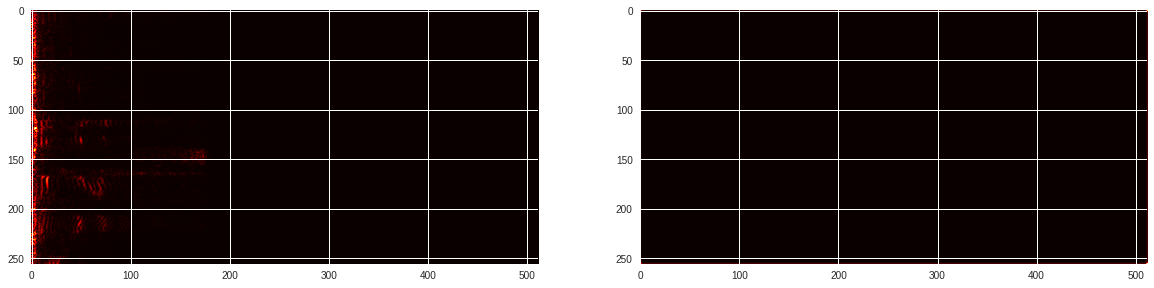

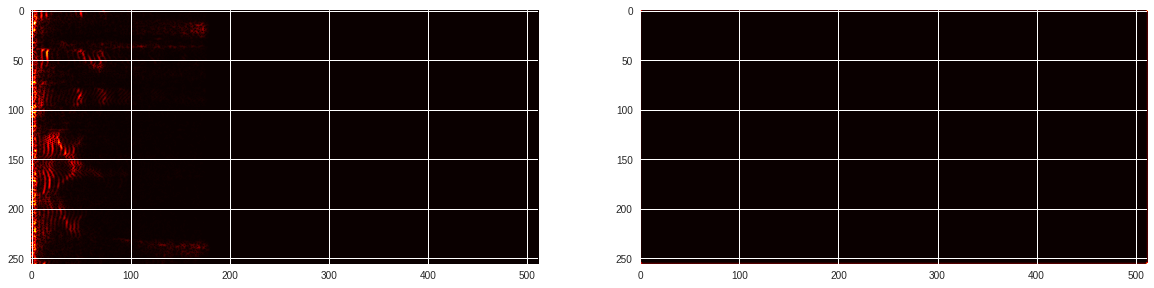

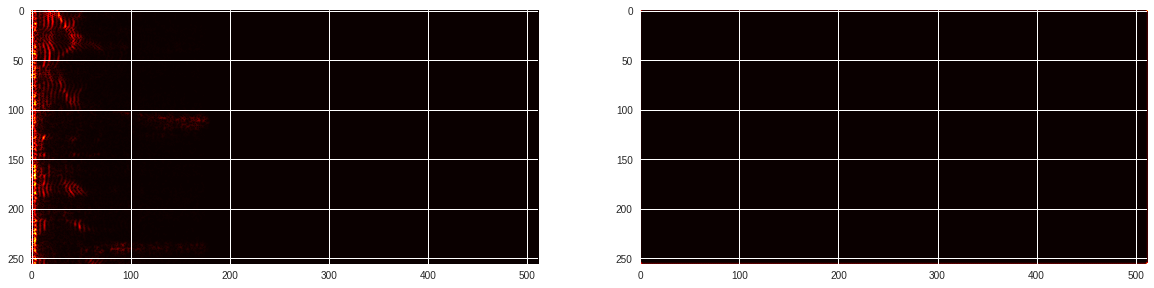

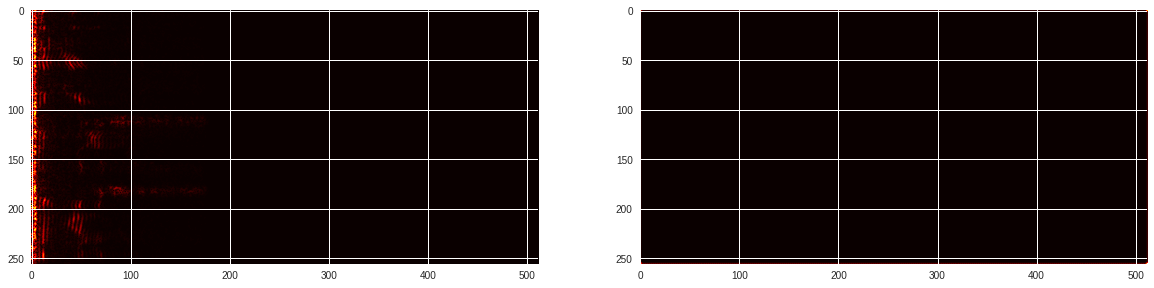

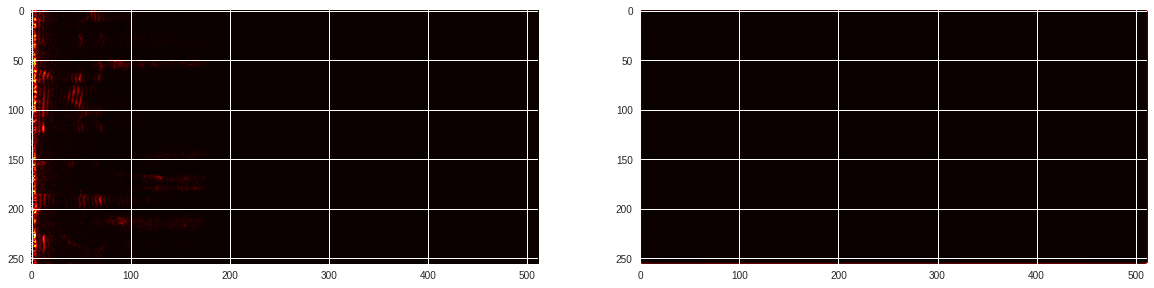

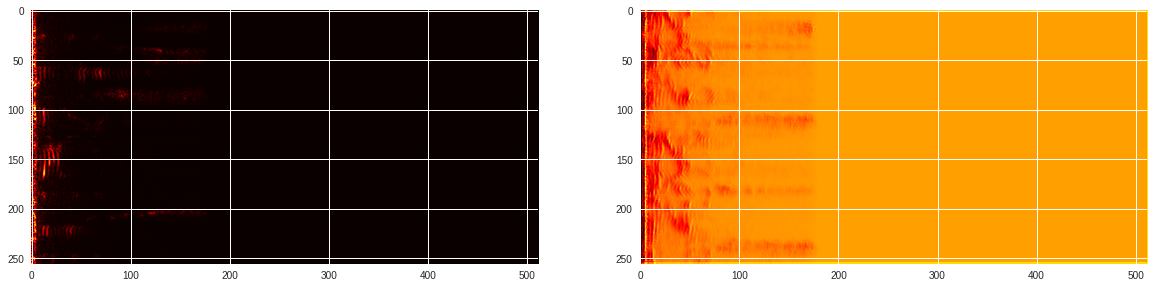

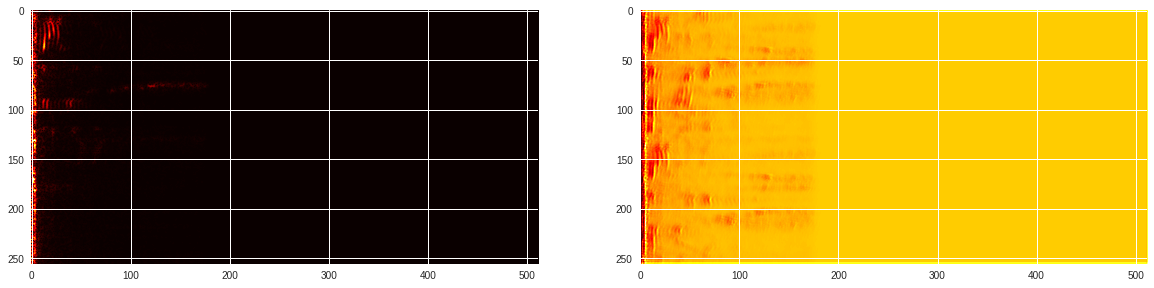

In [31]:
for i in range(spectrogram.shape[0]):
    fig, ((ax1,ax2)) = plt.subplots(1, 2, figsize=(20,20))
    ax1.imshow(spectrogram[i, :, :, 0])
    ax2.imshow(voice_spec_pred[i, :, :, 0])

Converting prediction back to file

In [0]:
def reverse_extract_spectrogram_patches(spec):
    spec2 = spec.reshape(1,-1,512,1)
    
    with tf.Session() as sess:
        patches = tf.extract_image_patches(
            images=spec2,
            ksizes=[1, 128, 512, 1],
            strides=[1, 256, 512, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        ).eval()

    return np.concatenate((patches.reshape(1,-1,512,1), spec2[:,-128:,:,:]), axis=1)

In [0]:
spectrogram=spectrogram*norm

spectrogram_r = reverse_extract_spectrogram_patches(voice_spec_pred)
spectrogram_r2 = spectrogram_r[0,:,:,0].T
mag = np.vstack((spectrogram_r2, np.zeros((spectrogram_r2.shape[1]))))
n = phase.shape[1] // 128 * 128
phase = phase[:,:n]
write_wav(f'test.wav', istft(mag*phase, win_length=1024, hop_length=256, window='hann'), 44100, norm=True)